In [2]:
import json

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker

import numpy as np

import openturns as ot
import openturns.viewer as viewer
import openturns.viewer as otv

import pickle

plt.rcParams['figure.dpi']= 500
plt.rcParams['text.usetex'] = True

# Importing data

In [3]:
labels = [
    r"$\alpha$",
    r"$\beta$",
    r"$\epsilon_e$",
    r"$\epsilon_c$",
    r"$d_p$",
    r"$\Gamma_{p}(0)$",
    r"$a_v$"
]

In [4]:
# Input-Output of THYC-Puffer-DEPOTHYC in Ho
# Hot leg
dataset_HL = ot.Sample.ImportFromCSVFile('../../data/SG_MC_HL.csv')

In [5]:
# Time indices in days
t = np.load('../../data/SG_time.npy')

In [6]:
# Input sample
inputSample = dataset_HL[:,:7]

In [7]:
# Clogging output as a function of time
outputSample = dataset_HL[:,7:]

In [8]:
# Parameters of the Steam Generator
input_dic = {}
input_dic['SG'] = json.load(open('../../data/SG_cleaning_conditioning.json'))

In [9]:
# Color scheme for chemical conditioning
colors_n = {'Morpholine': {'9.2': 'lightgreen', '9.6': 'forestgreen'},
             'ETA': {'9.6': 'slateblue'}}

In [10]:
# Probability distributions 
distribution_alpha = ot.Normal(101.6612, 4.0)
distribution_alpha.setDescription([r"$\alpha$"])
#
distribution_beta = ot.Normal(0.0233, 0.0005)
distribution_beta.setDescription([r"$\beta$"])
#
distribution_epsilon_e = ot.Triangular(0.2, 0.3, 0.5)
distribution_epsilon_e.setDescription([r"$\epsilon_e$"])
#
distribution_epsilon_c = ot.Triangular(0.0, 0.05, 0.3)
distribution_epsilon_c.setDescription([r"$\epsilon_c$"])
#
dp_factor = 1.0e-6
distribution_dp = ot.Triangular(0.5 * dp_factor, 5.0 * dp_factor, 10.0 * dp_factor)
distribution_dp.setDescription([r"$d_p$"])
#
distribution_gamma_p0 = ot.Triangular(1.0e-09, 4.5e-09, 8.0e-09)
distribution_gamma_p0.setDescription([r"$\Gamma_p(0)$"])
#
distribution_av = ot.Triangular(0.1e-4, 7.8e-4, 12e-4)
distribution_av.setDescription([r"$a_v$"])
#
distributionList = [
    distribution_alpha,
    distribution_beta,
    distribution_epsilon_e,
    distribution_epsilon_c,
    distribution_dp,
    distribution_gamma_p0,
    distribution_av,
]

distribution = ot.ComposedDistribution(distributionList)
# Workaround for https://github.com/openturns/openturns/issues/2255
labels = [marginal.getDescription()[0] for marginal in distributionList]

# Compute the PCE metamodel

In [11]:
def ComputeSparseLeastSquaresChaos(
    inputTrain, outputTrain, multivariateBasis, totalDegree, distribution
):
    """
      Create a sparse polynomial chaos based on least squares.

      * Uses the enumerate rule in basis.
      * Uses the LeastSquaresStrategy to compute the coefficients based on
        least squares.
      * Uses LeastSquaresMetaModelSelectionFactory to use the LARS selection method.
      * Uses FixedStrategy in order to keep all the coefficients that the
        LARS method selected.

    Source : https://openturns.github.io/openturns/latest/auto_meta_modeling/polynomial_chaos_metamodel/plot_chaos_cv.html
    with a bug fix: replace getStrataCumulatedCardinal with getBasisSizeFromTotalDegree

      Parameters
      ----------
      inputTrain : Sample
          The input design of experiments.
      outputTrain : Sample
          The output design of experiments.
      multivariateBasis : Basis
          The multivariate chaos basis.
      totalDegree : int
          The total degree of the chaos polynomial.
      distribution : Distribution.
          The distribution of the input variable.

      Returns
      -------
      result : PolynomialChaosResult
          The estimated polynomial chaos.
    """
    selectionAlgorithm = ot.LeastSquaresMetaModelSelectionFactory()
    projectionStrategy = ot.LeastSquaresStrategy(
        inputTrain, outputTrain, selectionAlgorithm
    )
    enumerateFunction = multivariateBasis.getEnumerateFunction()
    basisSize = enumerateFunction.getBasisSizeFromTotalDegree(totalDegree)  # OK
    adaptiveStrategy = ot.FixedStrategy(multivariateBasis, basisSize)
    chaosalgo = ot.FunctionalChaosAlgorithm(
        inputTrain, outputTrain, distribution, adaptiveStrategy, projectionStrategy
    )
    chaosalgo.run()
    result = chaosalgo.getResult()
    return result

In [12]:
# Define the polynomial basis
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    distributionList
)

In [13]:
multivariateBasis

class=OrthogonalProductPolynomialFactory univariate polynomial collection=[class=OrthogonalUniVariatePolynomialFamily implementation=class=StandardDistributionPolynomialFactory hasSpecificFamily=true specificFamily=class=OrthogonalUniVariatePolynomialFamily implementation=class=HermiteFactory measure=class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1],class=OrthogonalUniVariatePolynomialFamily implementation=class=StandardDistributionPolynomialFactory hasSpecificFamily=true specificFamily=class=OrthogonalUniVariatePolynomialFamily implementation=class=HermiteFactory measure=class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1],class=OrthogonalUniVariatePolynomialFamily implementation=class=StandardDistributionPolynomialFactory hasSpecificFamily=false orthonormalization algorithm=class=OrthonormalizationAlgorithm implementation=class=AdaptiveStieltjesAlgorithm measure=class=Triangular name=Triangular dimension=1 a=-1 m=-0.333333 b=1 monicRecurrenceCoefficients=class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=2 dimension=3 data=[[1,0.111111,0],[1,-0.015873,-0.17284]] monicSquaredNorms=class=Point name=Unnamed dimension=2 values=[1,0.17284] isElliptical=false,class=OrthogonalUniVariatePolynomialFamily implementation=class=StandardDistributionPolynomialFactory hasSpecificFamily=false orthonormalization algorithm=class=OrthonormalizationAlgorithm implementation=class=AdaptiveStieltjesAlgorithm measure=class=Triangular name=Triangular dimension=1 a=-1 m=-0.666667 b=1 monicRecurrenceCoefficients=class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=2 dimension=3 data=[[1,0.222222,0],[1,0.00143369,-0.191358]] monicSquaredNorms=class=Point name=Unnamed dimension=2 values=[1,0.191358] isElliptical=false,class=OrthogonalUniVariatePolynomialFamily implementation=class=StandardDistributionPolynomialFactory hasSpecificFamily=false orthonormalization algorithm=class=OrthonormalizationAlgorithm implementation=class=AdaptiveStieltjesAlgorithm measure=class=Triangular name=Triangular dimension=1 a=-1 m=-0.0526316 b=1 monicRecurrenceCoefficients=class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=2 dimension=3 data=[[1,0.0175439,0],[1,-0.00348288,-0.166821]] monicSquaredNorms=class=Point name=Unnamed dimension=2 values=[1,0.166821] isElliptical=false,class=OrthogonalUniVariatePolynomialFamily implementation=class=StandardDistributionPolynomialFactory hasSpecificFamily=false orthonormalization algorithm=class=OrthonormalizationAlgorithm implementation=class=AdaptiveStieltjesAlgorithm measure=class=Triangular name=Triangular dimension=1 a=-1 m=-1.18169e-16 b=1 monicRecurrenceCoefficients=class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=2 dimension=3 data=[[1,0,0],[1,0,-0.166667]] monicSquaredNorms=class=Point name=Unnamed dimension=2 values=[1,0.166667] isElliptical=true,class=OrthogonalUniVariatePolynomialFamily implementation=class=StandardDistributionPolynomialFactory hasSpecificFamily=false orthonormalization algorithm=class=OrthonormalizationAlgorithm implementation=class=AdaptiveStieltjesAlgorithm measure=class=Triangular name=Triangular dimension=1 a=-1 m=0.294118 b=1 monicRecurrenceCoefficients=class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=2 dimension=3 data=[[1,-0.0980392,0],[1,0.0152115,-0.171473]] monicSquaredNorms=class=Point name=Unnamed dimension=2 values=[1,0.171473] isElliptical=false] measure=class=Composed

In [19]:
split_fraction = 0.75
totalDegree = 4

training_sample_size = inputSample.getSize()

X_train = ot.Sample(inputSample)
Y_train = ot.Sample(outputSample)
split_index = int(split_fraction * training_sample_size)

X_test = X_train.split(split_index)
Y_test = Y_train.split(split_index)

chaosResult = ComputeSparseLeastSquaresChaos(
        X_train, Y_train, multivariateBasis, totalDegree, distribution
    )

WRN - set the component 1 of contributor 7=0 to zero as it is too small
WRN - set the component 2 of contributor 7=0 to zero as it is too small
WRN - set the component 3 of contributor 7=0 to zero as it is too small
WRN - set the component 4 of contributor 7=0 to zero as it is too small
WRN - set the component 5 of contributor 7=0 to zero as it is too small
WRN - set the component 6 of contributor 7=0 to zero as it is too small
WRN - set the component 7 of contributor 7=0 to zero as it is too small
WRN - set the component 8 of contributor 7=0 to zero as it is too small
WRN - set the component 9 of contributor 7=0 to zero as it is too small
WRN - set the component 10 of contributor 7=0 to zero as it is too small
WRN - set the component 11 of contributor 7=0 to zero as it is too small
WRN - set the component 12 of contributor 7=0 to zero as it is too small
WRN - set the component 13 of contributor 7=0 to zero as it is too small
WRN - set the component 14 of contributor 7=0 to zero as it 

l
WRN - set the component 23 of contributor 12=0 to zero as it is too small
WRN - set the component 24 of contributor 12=0 to zero as it is too small
WRN - set the component 25 of contributor 12=0 to zero as it is too small
WRN - set the component 26 of contributor 12=0 to zero as it is too small
WRN - set the component 27 of contributor 12=0 to zero as it is too small
WRN - set the component 28 of contributor 12=0 to zero as it is too small
WRN - set the component 29 of contributor 12=0 to zero as it is too small
WRN - set the component 30 of contributor 12=0 to zero as it is too small
WRN - set the component 31 of contributor 12=0 to zero as it is too small
WRN - set the component 32 of contributor 12=0 to zero as it is too small
WRN - set the component 33 of contributor 12=0 to zero as it is too small
WRN - set the component 34 of contributor 12=0 to zero as it is too small
WRN - set the component 35 of contributor 12=0 to zero as it is too small
WRN - set the component 36 of contri

# Import PCE metamodel


In [14]:
file = open('../../data/metamodel_PCE.pkl', 'rb')
pce = pickle.load(file)

In [15]:
inputSample = np.asarray(inputSample)
outputSample = np.asarray(outputSample)

In [16]:
inputTest, outputTest = inputSample[750:, :], outputSample[750:, :]
val = ot.MetaModelValidation(inputTest, outputTest, pce)

In [17]:
Q2 = val.computePredictivityFactor()

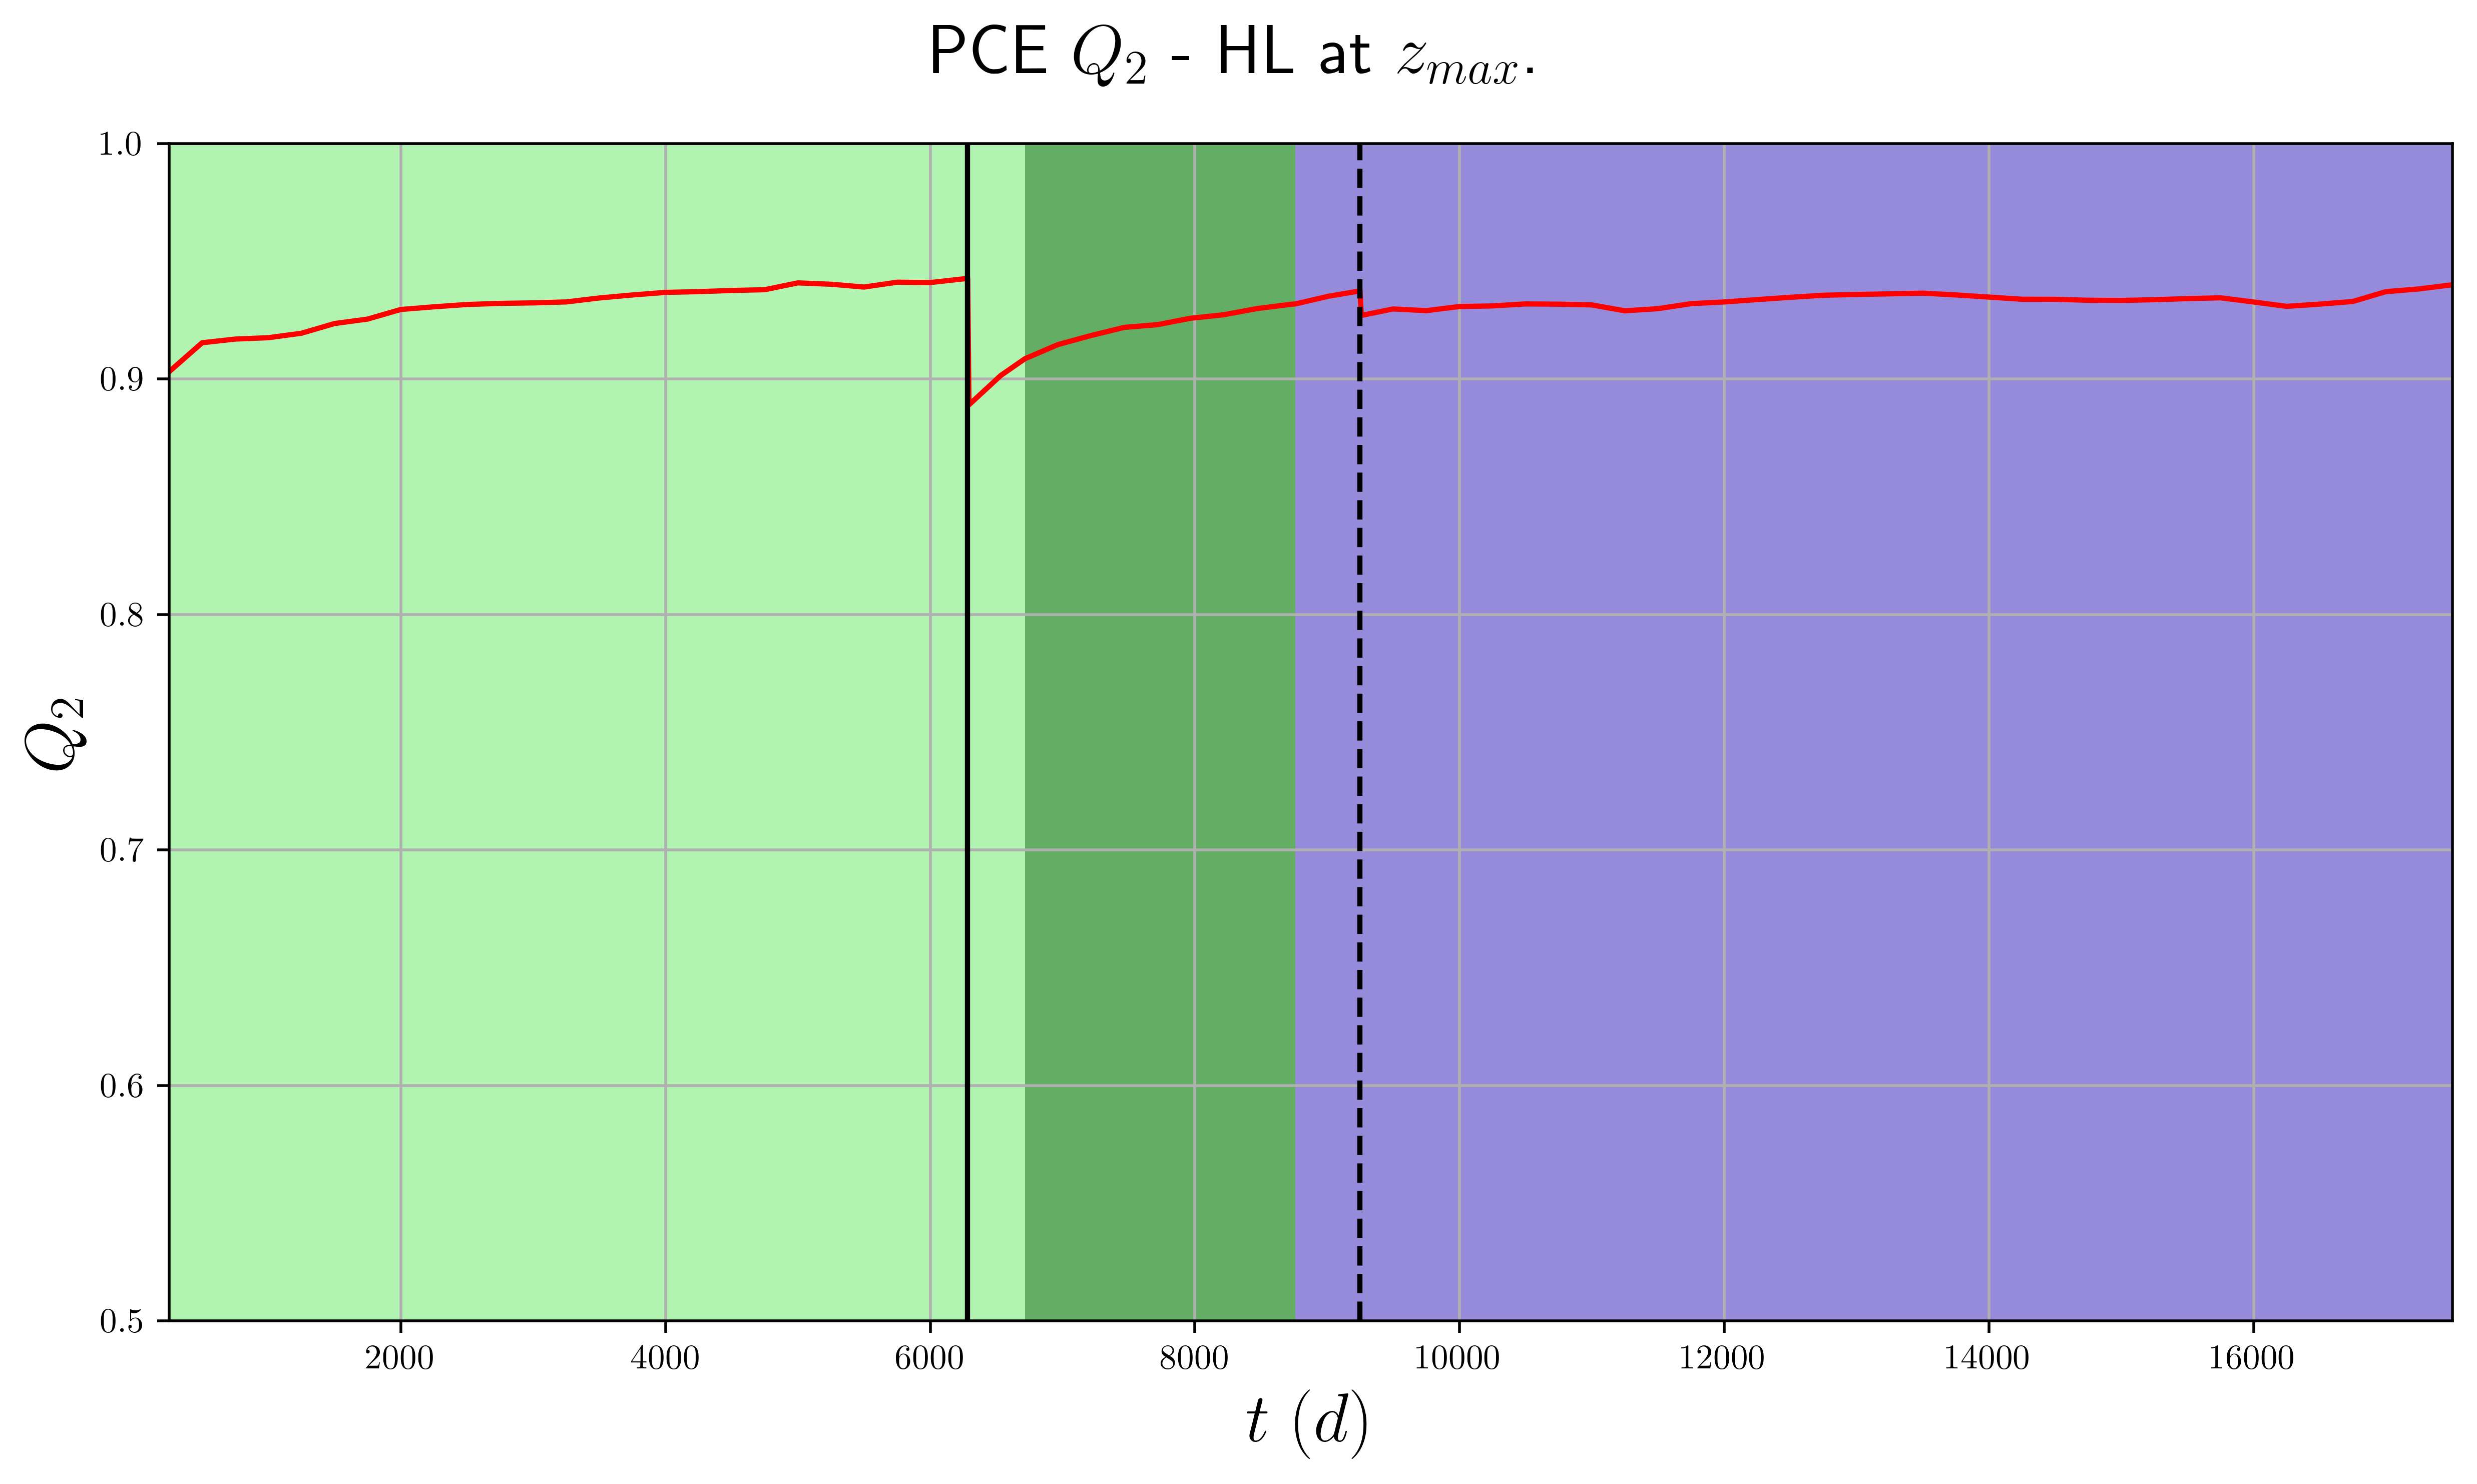

In [18]:
nrow, ncol = 1, 1
fig, axs = plt.subplots(nrow, ncol, figsize=(10,6), layout='tight')

#Chemical conditioning
cond = input_dic['SG']['chimie']['conditionnementSecondaire']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, max(t)
    else:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, cond[k+1]['nbHeuresExploit']/24
    c = cond[k]
    typ = colors_n[c['type']]
    col = typ[str(c['ph'])]
    axs.axvspan(t_i, t_f, facecolor=col, alpha=0.7, label='{0}, pH= {1}'.format(c['type'], c['ph']))

#Clogging trajectories
axs.grid()
axs.plot(t, Q2, c='r')
axs.set_xlim(250,17500)
axs.set_ylim(0.5,1.0)
axs.set_xlabel(r'$t\;(d)$', fontsize=20)
axs.set_ylabel(r'$Q_{2}$', fontsize=20)

#Cleaning dates
nett = input_dic['SG']['chimie']['nettoyage']
for k in range(len(nett)):
    if nett[k]['type'] == 'curatif':
        axs.axvline(x=nett[k]['nbHeuresExploit']/24, color='k', linestyle='-', linewidth=1.5, label='Curative cleaning')

    elif nett[k]['type'] == 'preventif':
        axs.axvline(x=nett[k]['nbHeuresExploit']/24, color='k', linestyle='--', linewidth=1.5, label='Preventive cleaning')

#Legend
#lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
#lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
#fig.legend(lines, labels, bbox_to_anchor=(-0.01,0.7), fontsize=15)

fig.suptitle(r'PCE $Q_{2}$  - HL at $z_{max}$.', fontsize=20)
fig.savefig('../../plots/PCE/TPD_PCE_Q2.pdf', format='pdf', bbox_inches='tight')
fig.savefig('../../plots/PCE/TPD_PCE_Q2.png', format='png', bbox_inches='tight')

In [19]:
new_sample = distribution.getSample(10000)
output_sample = pce(new_sample)


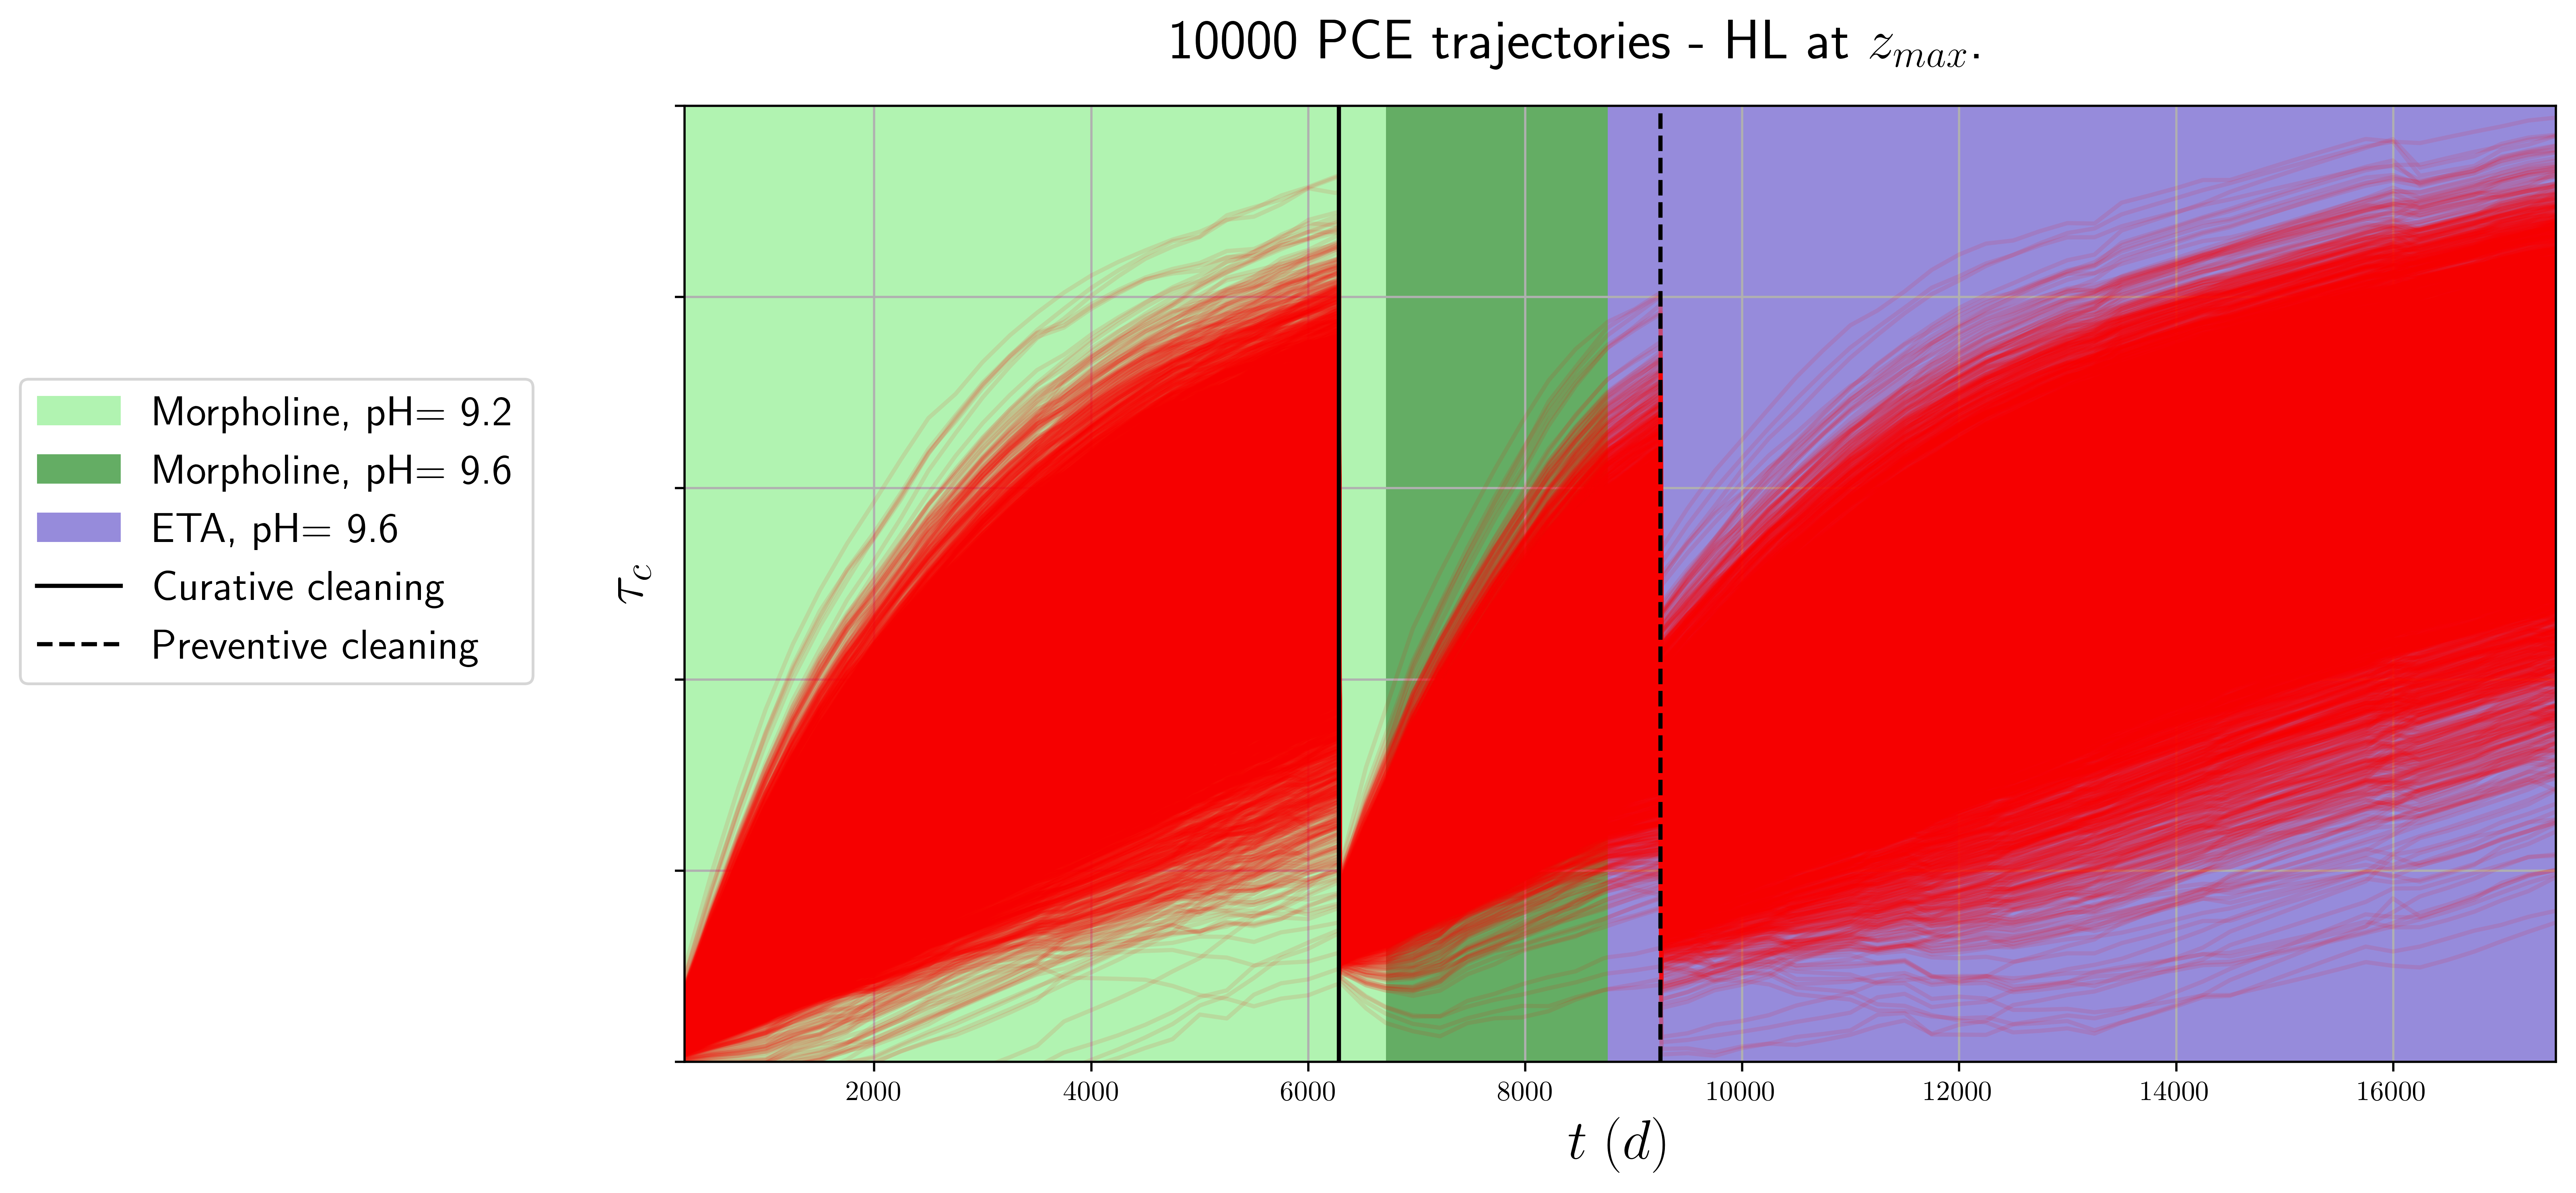

In [21]:
nrow, ncol = 1, 1
fig, axs = plt.subplots(nrow, ncol, figsize=(10,6), layout='tight')

#Chemical conditioning
cond = input_dic['SG']['chimie']['conditionnementSecondaire']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, max(t)
    else:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, cond[k+1]['nbHeuresExploit']/24
    c = cond[k]
    typ = colors_n[c['type']]
    col = typ[str(c['ph'])]
    axs.axvspan(t_i, t_f, facecolor=col, alpha=0.7, label='{0}, pH= {1}'.format(c['type'], c['ph']))

#Clogging trajectories
axs.grid()
for i in range(10000):
    axs.plot(t, output_sample[i], c='r', alpha=0.1)
axs.set_xlim(250,17500)
axs.set_ylim(0,100)
axs.axes.yaxis.set_ticklabels([])
axs.set_xlabel(r'$t\;(d)$', fontsize=20)
axs.set_ylabel(r'$\tau_c$', fontsize=20)

#Cleaning dates
nett = input_dic['SG']['chimie']['nettoyage']
for k in range(len(nett)):
    if nett[k]['type'] == 'curatif':
        axs.axvline(x=nett[k]['nbHeuresExploit']/24, color='k', linestyle='-', linewidth=1.5, label='Curative cleaning')

    elif nett[k]['type'] == 'preventif':
        axs.axvline(x=nett[k]['nbHeuresExploit']/24, color='k', linestyle='--', linewidth=1.5, label='Preventive cleaning')

#Legend
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, bbox_to_anchor=(-0.01,0.7), fontsize=15)

fig.suptitle(r'10000 PCE trajectories - HL at $z_{max}$.', fontsize=20)
fig.savefig('../../plots/PCE/TPD_PCE_ex.pdf', format='pdf', bbox_inches='tight')
fig.savefig('../../plots/PCE/TPD_PCE_ex.png', format='png', bbox_inches='tight')

        